<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/boris/Main_PIE_Real_case_copie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lopesmatheus/COA19-PythonSimu/blob/main/Main_PIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIE - Apprentissage par renforcement pour le contrôle optimal des systèmes d’air

Ce notebook a pour objet de répondre au besoin exprimé par Liebherr Aerospace et qui s'inscrit dans le PIE-COA19 "Apprentissage par renforcement pour le contrôle optimal des systèmes d'air".

0. [Prérequis](#sec0)
    1. [À jouer sous Colab](#sec0-1)
    2. [Modules](#sec0-2)
1. [Environnements](#sec1)
2. [Agent](#sec2)
3. [Algorithmes (Actor-Critic)](#sec3)
    1. [Deep-Deterministic Policy Gradient (DDPG)](#sec3-1)
        1. [Essai sur environnement jouet CarPend](#sec3-1-1)
        2. [Environnement PLANT](#sec3-1-2)
    2. [Soft Actor-critic (SAC)](#sec3-2)
        1. [Exemple jouet LunarLander](#sec3-2-1)
        2. [Essai sur environnement jouet CarPend](#sec3-2-2) 
        3. [Environnement PLANT](#sec3-2-3) 

# <a id="sec0"></a> 0. Prérequis

### <a id="sec0-1"></a> 0.1. À jouer sous Colab

À exécuter si le notebook est joué sous Colab.

In [ ]:
!pip install gym[box2d]

In [ ]:
!pip install pytorch

In [1]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 KB 9.6 MB/s eta 0:00:00


### <a id="sec0-2"></a> 0.2. Modules

In [3]:
import gym
import time
import shutil
import pandas as pd
import numpy as np
import random
import torch
from torch import nn
from statistics import mean
import matplotlib.pyplot as plt
import copy
from scipy.integrate import odeint

# <a id="sec1"></a> 1. Environnements

### <a id="sec1-2"></a> 1.2. Environnement PLANT

Cette section vise à implémenter l'environnement PLANT en utilisant le formalisme gym.

In [4]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave

In [35]:
# define the model name and simulation parameters

class PlantEnv:
    def __init__(self,CaseTest,Hysteresis,step_size):
        self.action_scale=300
        self.Hysteresis = Hysteresis
        
        self.CaseTest = CaseTest
        
        self.action_space = gym.spaces.Box(0,1000,(1,),np.float64)

        self.observation_space=gym.spaces.Box(np.array([-100.0 for i in range(11)]),np.array([1000.0 for i in range(11)]),(11,),np.float64)

        fmu_plant_filename = 'PLANT_v3_linux.fmu'
        self.step_size = step_size
        
        self.Tend = self.CaseTest.getTsimu() - self.CaseTest.getTend()

        # read the model description
        plant_description = read_model_description(fmu_plant_filename)

        # collect the value references
        self.plant_vrs = {}
        for variable in plant_description.modelVariables:
            self.plant_vrs[variable.name] = variable.valueReference

        self.inputs_plant = [v for v in plant_description.modelVariables if v.causality == 'input']
        self.outputs_plant = [v for v in plant_description.modelVariables if v.causality == 'output']

        input_plant_order = []
        
        for v in self.inputs_plant:
            input_plant_order.append(v.valueReference)

        self.CaseTest.setInputOrder(input_plant_order)

        # extract the FMU
        self.unzipdir_plant = extract(fmu_plant_filename)

        self.fmu_plant = FMU2Slave(guid=plant_description.guid,
                             unzipDirectory=self.unzipdir_plant,
                             modelIdentifier=plant_description.coSimulation.modelIdentifier,
                             instanceName='instance1')

        # initialize
        self.fmu_plant.instantiate()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        self.state=np.zeros((self.observation_space.shape[0],))
        self.previous_i=np.zeros((1,))
        self._max_episode_steps=3100
    def reset(self):
        self.fmu_plant.reset()
        self.fmu_plant.setupExperiment(startTime=0)
        self.fmu_plant.enterInitializationMode()
        self.fmu_plant.exitInitializationMode()
        
        self.fmu_plant.setReal([self.inputs_plant[1].valueReference], [self.Hysteresis])       # HYSTERESIS 
        
        for cst in self.CaseTest.getConstantsInputs():
            vr = self.inputs_plant[cst].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,0)])
            
        self.counter = 0
        self.time = 0
        self.state=np.zeros((self.observation_space.shape[0],))

        for i in range(500):
          self.state, reward, done, _ = self.step(0)

          
        return(self.state)
        
    def step(self, action):
        for var in self.CaseTest.getVariablesInputs():
            vr = self.inputs_plant[var].valueReference
            self.fmu_plant.setReal([vr], [self.CaseTest.getAll(vr,self.counter)])
        self.fmu_plant.setReal([self.inputs_plant[0].valueReference], [action])

        self.fmu_plant.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
        
        self.counter += 1
        self.time += self.step_size
        
        if self.time < self.Tend:
            done = False
        else:
            done = True

        for i in range(1,self.state.shape[0]-1):
          self.state[i]=self.state[i+1]

        
        self.state[0]=self.previous_i

        TBAS_SENSOR = self.fmu_plant.getReal([self.outputs_plant[4].valueReference])[0]
        FAV_POSITION_DEG = self.fmu_plant.getReal([self.outputs_plant[0].valueReference])[0]
        
        T_target = self.CaseTest.getT_tgt_C()
        
        error = abs((TBAS_SENSOR - T_target[0]))

        reward = - error*self.time  #- (self.state[0]-action[0])**4#- max(self.time-60,0)/(self.time+1) * max(error-10,0) -  max(self.time-120,0) * max(error-5,0)/(self.time+1)  
        self.state[self.state.shape[0]-1]=TBAS_SENSOR
        self.previous_i=action
        return self.state, reward, done, _
    
    def kill_plant(self):
        self.fmu_plant.terminate()
        self.fmu_plant.freeInstance()

        # clean up
        shutil.rmtree(self.unzipdir_plant, ignore_errors=True)

# <a id="sec2"></a> 2. Agent

To simplify the global code of this notebook, we will use a mother class for each of our agents. This will allow us to build a simulation function that take in argument an environment and an agent, and work with any agents and any environments. Then all you will have to do is to describe what the agent should do at each step of the learning.

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
class ReplayBuffer:
    def __init__(self, capacity, device=DEVICE):
        self.capacity = capacity # capacity of the buffer
        self.device = device
        self.data = []
        self.index = 0 # index of the next cell to be filled

    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(x).to(self.device), list(zip(*batch))))

    def __len__(self):
        return len(self.data)

cuda


In [7]:
class Agent:
    """
    An global agent class that describe the interactions between our agent and it's environment
    """
    def __init__(self, state_space, action_space, device=DEVICE, name="base_agent"):

        self.name = name  # The name is used inside plot legend, outputs directory path, and outputs file names

        self.state_space = state_space
        self.state_shape = state_space.shape
        self.state_size = state_space.shape[0]  # Assume state space is continuous

        self.continuous = isinstance(action_space, gym.spaces.Box)
        self.action_space = action_space
        self.nb_actions = self.action_space.shape[0] if self.continuous else self.action_space.n
        self.last_state = None  # Useful to store interaction when we recieve (new_stare, reward, done) tuple
        self.device = device
        self.episode_id = 0
        self.episode_time_step_id = 0
        self.time_step_id = 0
    
    def on_simulation_start(self):
        """
        Called when an episode is started. will be used by child class.
        """
        pass
    
    def on_episode_start(self, state):
        self.last_state = state
        self.episode_time_step_id = 0
        self.episode_id = 0

    def action(self, state):
        res = self.action_space.sample()
        return res

    def on_action_stop(self, action, new_state, reward, done):
        self.episode_time_step_id += 1
        self.time_step_id += 1
        self.last_state = new_state

    def on_episode_stop(self):
        self.episode_id += 1

    def on_simulation_stop(self):
        pass

Now let's build a function that run a simulation where a given agent interact with a givent environment. 

# <a id="sec3"></a> 3. Algorithmes (Actor-Critic)

<div id="actor_critic"></div>
To understand in detail how it work, we are going to implement two of the most known off-policy actor critic architectures, Deep-Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). 

### <a id="sec3-1"></a> 3.1. Deep-Deterministic Policy Gradient (DDPG)
<div id="ddpg"></div>

DDPG is considered as an off-policy algorithm, because the policy used to train the critic is different than the one used to generate samples.

For the general idea, when we select an interaction (s, a, r, s', a') to train our critic network, the way a' will be chosen will define the reward propagation (generally called credit assignment) speed. If a' is the optimal action from s', like in DQN, there is a high probability to get an action that lead in interestig and highly valuated states s''. In that case, the high values and the rewards will be propagated to (s, a) value, more frequently than s'' with low value.

If you didn't got it, you can also check this course from Olivier SIGAUD on youtube : https://youtu.be/hlhzvQnXdAA

Note that the default DDPG algorithm don't use epsilon-greedy, but add a noise on the action to make it explore. The original paper use a OU-noise, but for simplicity, we will generate a gaussian noise N(mean, std) to noise our action.


In [45]:
from torch import optim

def init_weights(layer, bound=None):
    if bound is None:
      
        bound = 1. / np.sqrt(layer.weight.data.size()[0])
        bound=10.0
    torch.nn.init.uniform_(layer.weight.data, -bound, bound)
    torch.nn.init.uniform_(layer.bias.data, -bound, bound)


class DefaultNN(nn.Module):
    def __init__(self, learning_rate, input_dims, layer_1_dims, layer_2_dims, output_dims, device,
                 last_activation=None):
        super().__init__()
        self.last_activation = last_activation
        self.layer_1 = nn.Linear(input_dims, layer_1_dims)
        init_weights(self.layer_1)
        self.layer_norm_1 = nn.LayerNorm(layer_1_dims)

        self.layer_2 = nn.Linear(layer_1_dims, layer_2_dims)
        init_weights(self.layer_2)
        self.layer_norm_2 = nn.LayerNorm(layer_2_dims)

        self.layer_3 = nn.Linear(layer_2_dims, output_dims)
        init_weights(self.layer_3, bound=0.003)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.device = device
        self.to(self.device)

    def forward(self, inputs):
        running_output = self.layer_1(inputs)
        running_output = self.layer_norm_1(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_2(running_output)
        running_output = self.layer_norm_2(running_output)
        running_output = torch.nn.functional.relu(running_output)
        running_output = self.layer_3(running_output)

        if self.last_activation is not None:
            running_output = self.last_activation(running_output)
        return running_output

    def converge_to(self, other_model, tau=0.01):
        """
        Make the value of parameters of this model converge to one from the given model.
        The parameter tau indicate how close our weights should be from the one of the other model.
        self.converge_to(other_model, tau=1) is equivalent to self = copy.deepcopy(other_model).

        other_model should have the same shape, dimensions, than self.
        """
        for self_param, other_param in zip(self.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

In [32]:

def simulation(environment, agent, nb_episodes=200, verbose=True):
    episodes_rewards_sum = []
    agent.on_simulation_start()
    for episode_id in range(nb_episodes):
        state = environment.reset()
        agent.on_episode_start(state)

        episode_rewards = []
        done = False
        prev=np.zeros((1,))

        x=[]
        actions=[]
        while not done:

            #print(cartpole.state)


            action = agent.action(state)
            actions.append(action)
            x.append(state[-1])
            state, reward, done ,_= environment.step(action)

            
            # Ending time step process ...
            agent.on_action_stop(action, state, reward, done)

            # Store reward
            episode_rewards.append(reward)

        agent.on_episode_stop()
        rewards_sum = sum(episode_rewards)
        episodes_rewards_sum.append(rewards_sum)
        #environment.close()
        if len(episodes_rewards_sum) > 20:
            last_20_average = mean(episodes_rewards_sum[-20:])
        else:
            last_20_average = mean(episodes_rewards_sum)

        if verbose:
            print("Episode ", '{:3d}'.format(episode_id),
                  ", episode return ", '{:4.1f}'.format(rewards_sum),
                  ", last 20 avg ", '{:4.1f}'.format(last_20_average),
                  sep='')
            t=range(int(1.0/float(step_size)*1500))
            plt.figure()
            plt.plot(t,x)
            plt.plot(t,[CaseTest.getT_tgt_C() for i in range(1500)])
            plt.xlabel('t (step)')
            plt.ylabel('x')

            plt.figure()
            plt.plot(t,actions)

            plt.show()
    return episodes_rewards_sum

In [47]:
# %load solutions/RL6_DDPG.py
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

### NEW indicate the differences between DQN and DDPG.
class DDPGAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.001, critic_lr=0.0025, tau=0.001, gamma=0.9,
                 max_size=100000, layer1_size=512, layer2_size=512, batch_size=64, noise_std=0.05, name="DDPG"):
        assert isinstance(action_space, gym.spaces.Box)  ### NEW: The action space is now continuous 
        super().__init__(state_space, action_space, device=device, name=name)
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size

        self.actor = DefaultNN(actor_lr, self.state_size, layer1_size, layer2_size, self.nb_actions
                               , self.device,
                               last_activation=nn.Tanh())
        self.critic = DefaultNN(critic_lr, self.state_size + self.nb_actions, layer1_size, layer2_size, 1, self.device)

        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)

        self.normal_distribution = torch.distributions.normal.Normal(
            torch.zeros(self.nb_actions), torch.full((self.nb_actions,), noise_std))
        self.action_scale =10

    def action(self, observation):
        with torch.no_grad():
            #print(prev)
            #print(observation)
            observation = torch.tensor(observation, dtype=torch.float).to(self.device)
            #print(observation)
            actor_output = self.actor.forward(observation).to(self.device)
            #print(actor_output)
            #action=torch.normal(actor_output[0], np.abs(actor_output[1]))
            noise = self.normal_distribution.sample().to(self.device)
            #print(actor_output)
            #action = self.action_scale*(actor_output +noise)
            action = actor_output+noise #self.action_scale*torch.abs()
            #print(action)
        return 30*action.cpu().detach().numpy() +150

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)

    def learn(self):
        #if len(self.replay_buffer) > self.batch_size:
        if len(self.replay_buffer.data) > self.batch_size:
            states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)

            with torch.no_grad():
                target_actions = self.target_actor.forward(new_states)
                critic_value_ = self.target_critic.forward(torch.concat((new_states, target_actions), dim=-1))
            critic_value = self.critic.forward(torch.concat((states, actions), dim=-1))
            target = torch.addcmul(rewards, self.gamma, 1 - dones, critic_value_.squeeze()).view(self.batch_size, 1)
            self.critic.optimizer.zero_grad()
            critic_loss = torch.nn.functional.mse_loss(target, critic_value)
            critic_loss.backward()
            self.critic.optimizer.step()

            self.actor.optimizer.zero_grad()
            actions = self.actor.forward(states)
            actor_loss = - self.critic.forward(torch.concat((states, actions), dim=-1))
            actor_loss = torch.mean(actor_loss)
            actor_loss.backward()
            self.actor.optimizer.step()

            self.target_critic.converge_to(self.critic, tau=self.tau)
            self.target_actor.converge_to(self.actor, tau=self.tau)




#### <a id="sec3-1-2"></a> 3.1.2. Environnement PLANT

In [1]:
import sys
sys.path.append('../')
from A_T01a import A_T01a ##selectionner ici le cas test à utiliser.

Episode   0, episode return -147163340.4, last 20 avg -147163340.4


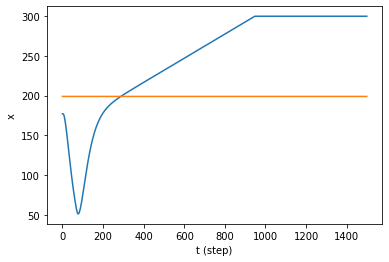

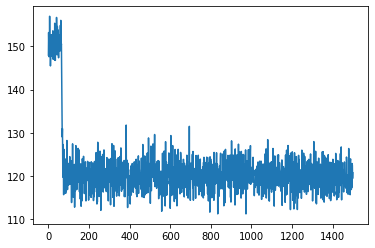

Episode   1, episode return -140122709.8, last 20 avg -143643025.1


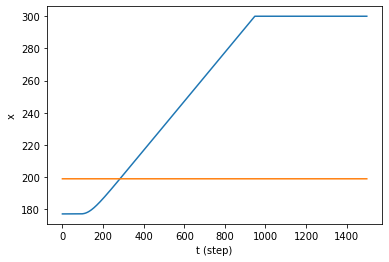

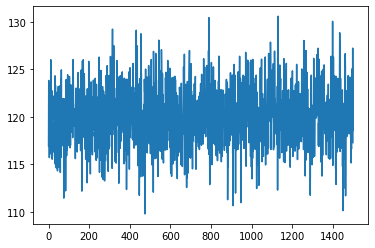

Episode   2, episode return -140122580.9, last 20 avg -142469543.7


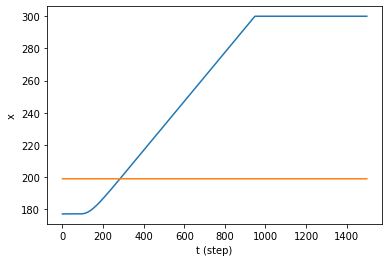

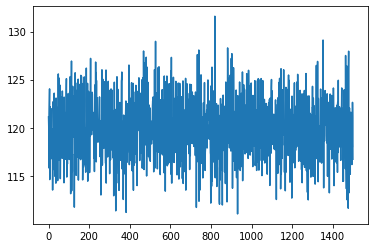

Episode   3, episode return -140117298.2, last 20 avg -141881482.4


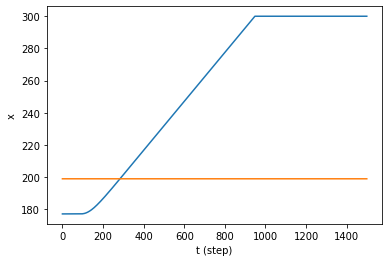

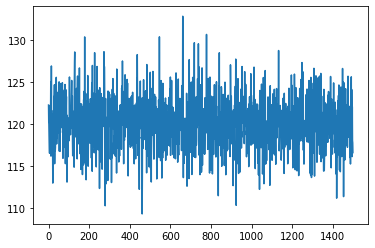

Episode   4, episode return -140125131.5, last 20 avg -141530212.2


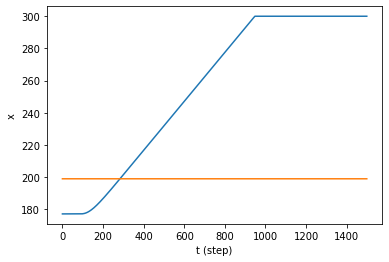

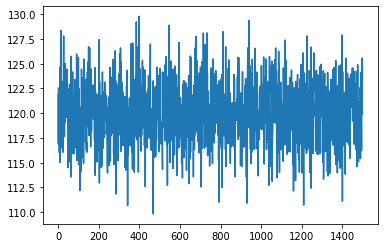

Episode   5, episode return -140127335.4, last 20 avg -141296399.4


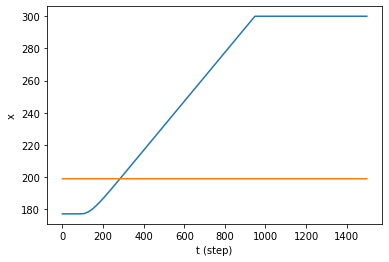

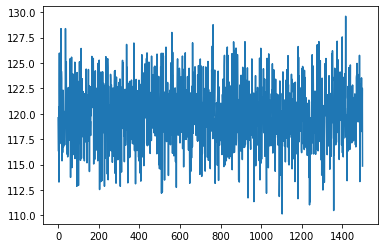

KeyboardInterrupt: ignored

In [48]:
step_size = 1
CaseTest = A_T01a(step_size)  
environment = PlantEnv(CaseTest,0.0,step_size)
agent = DDPGAgent(environment.observation_space, environment.action_space, noise_std=0.1, device=DEVICE)
simulation(environment, agent,nb_episodes=1000)

In [ ]:
torch.save(agent.actor.state_dict(), 'act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint.pth')

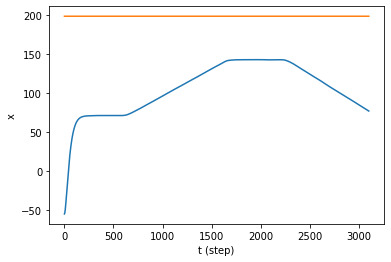

[-54.999266877923105, -54.914887671406774, -54.66367195334212, -54.2355497128963, -53.64196094303409, -52.901521073008894, -52.0322050239057, -51.05012723048404, -49.969321508450605, -48.80205793382626, -47.55910336286459, -46.24979521929873, -44.88221900425239, -43.46350290413599, -42.00011895566709, -40.49785695869258, -38.96191831430582, -37.396978828792896, -35.80717628990925, -34.196173924603215, -32.56740580640346, -30.924164983297516, -29.2695764207387, -27.60665466312969, -25.93814844696749, -24.266427596198326, -22.59362615234386, -20.921722925726954, -19.252526956101264, -17.58772510655527, -15.929008329094074, -14.278106570912655, -12.636608040198212, -11.00598824945746, -9.387636968761626, -7.782755539382663, -6.1924079808436545, -4.617640701899063, -3.059387603828668, -1.518496924052613, 0.00441657612839208, 1.5088866026760002, 2.994352561840458, 4.4603357803576955, 5.90640669488846, 7.332252894003318, 8.73763333270881, 10.122189611211127, 11.485562264997498, 12.8275278975

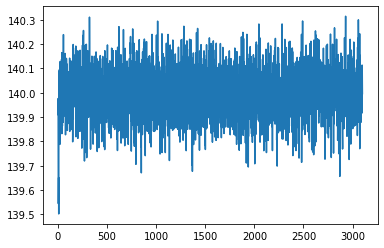

In [44]:
# There. we finished
# Lets see it in action
step_size = 1
CaseTest = A_T01a(step_size)
cartpole = PlantEnv(CaseTest,0.0,step_size)

done = False
cnt = 0
observation = cartpole.reset()

t=[]
x=[]
xp=[]
th=[]
thp=[]
actions=[]
while not done :
    cnt += 1
    t.append(cnt)
    #print(cartpole.state)
    prev=[0]
    action = agent.action(observation)
    #action =max(cnt-1000,0)
    #print(action)
    actions.append(action)
    observation, reward, done,_ = cartpole.step(action)

    x.append(observation[2])
    #xp.append(observation[1])
    #th.append(observation[2])
    #thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.plot(t,[CaseTest.getT_tgt_C() for i in range(3100)])
plt.xlabel('t (step)')
plt.ylabel('x')


# plt.figure()
# plt.plot(t,xp)
# plt.xlabel('t (step)')
# plt.ylabel('v')

# plt.figure()
# plt.plot(t,np.array(th)*180/np.pi)
# plt.xlabel('t (step)')
# plt.ylabel('theta')

# plt.figure()
# plt.plot(t,thp)
# plt.xlabel('t (step)')
# plt.ylabel('theta point')
# #plt.figure()
#plt.plot(t,xpp)

plt.show()
print(x)
plt.plot(t,actions)

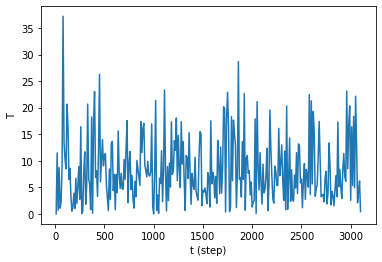

In [ ]:
# There. we finished
# Lets see it in action
plant=PlantEnv(CaseTest,0.0,step_size)
done = False
cnt = 0
observation = plant.reset()
t=[]
T=[]

while not done :
    cnt += step_size
    t.append(cnt)

    action = agent.action(observation)
    observation, reward, done,_ = plant.step(action)
    T.append(observation[0])

plt.figure()
plt.plot(t,T)
plt.xlabel('t (step)')
plt.ylabel('T')
plt.show()

### <a id="sec3-2"></a> 3.2. Soft Actor-critic (SAC)
<div id="sac"></div>

Soft Actor-Critic is really close to DDPG, except that it learn using a regularised entropy on actions policy.

#### Shanon entropy

Let X be a random variable with a law of density p(X) satisfying the normalization and positivity requirements, we define its entropy by
$$-\int_{X} p(x) log (p(x))$$

It allows to quantify the disorder of a random variable. The entropy is maximal when X follows an uniform distribution, and minimal when p(X) is equal to zero everywhere except in one value, which is a Dirac distribution.

#### Why entropy in SAC?

In SAC algorithm, we not only consider the critic evaluation inside the actor loss, but also it's decision entropy.
The loss of the agent should be high when the entropy is low, because it will invite him to explore more.
The mode the entropy of the agent is important, the more it will explore.

More, SAC use entropy to estimate next_states value. The more the entropy of the target actor is important while choosing a', the more s' will be condidered as highly valuable.
To illustrate the intiution behing this, let's imagine an environment with a discrete state space, in a sigle line: 


|    |    |    |
|:--:|:--:|:--:|
| +1 | A  | +1 |

In the exemple above, the agent (A) will recieve a reward of +1 at the next round, whatever the next action he will chose. Because the actor loss make him maximise critig grade and entropy, he will improve entropy when the critig grage cannot be improved anymore. In this case, the critic value will everytime be the same, whatever the action taken by the agent. For this reason, the action entropy will be maximize, so the agent will have the same probability to go in any directions.

This fact bring a side effect. Because states are consider good when the entropy of the action taken from them is high, the agent will maintain itself in states where he will be sake whatever the next taken action. This behavior is also present in DDPG but is strengten here but the entropy maximisation, making our agent gain in stability (you will observe the gap in performances standard deviation latter).


|    |    |    |
|:--:|:--:|:--:|
| -1 | A  | +1 |

In this new case, the entropy of the action will be low because the actor loss will be lower if the critic evaluation is high, so he should choose deterministic action that leads to states with the higher value.

In other words, we can say that SAC will perform a better exploration/exploitation trade-off, by takin both the advantage of a high exploration, and the advantage of a high exploitation. He will maximize exploration by mawimising entropy, but will not suffer from the incovenient of high exploration that is fall in bad state and never enstrenght the optimal trajectory the the best rewards, because he will fly away from bad rewarding states.


#### How to use entropy in SAC?

To compute an entropy, we need the actor to give use a random distribution. The most common way to archieve that, is to make the actor with 2 * nb_action outputs neurons, giving actions means and standard deviations.

Because the standart deviation, it is common to make the actor return the log(std), and then get the real std with $e^{log_std}$. But we can also put the std output inside a relu().

To get the action, we can sample actions from the means and standard deviations we got. Doing this will prevent us latter to retro-propagate the gradient when we will train our actor, so we should do a reparametrization trick when we want to compute actions for actor training (more explanation in the code to fill bellow).
Sample with reparametrisation is equivalent to compute $a = \mu + \mathcal{N}(0,\,1)\ * sigma$.

In general, for a given a', we maximise entropy my minimising $log (p(x))$. Looking at the entropy function, we can understand that $log(p(x))$ have a higher impact than p(x) only, because p(x) is between 0 and 1, and $|log(p(x))|$ is generally extremly high because p(x) is generally close to 0.

Because our environment action space is bounded, but our normal distribution is not, we can put the actions we got inside tanh function to get some between -1 and 1, and then scale it to our environment action space. Because we bould our actions, we should do a process over our log prob as follow:

        log_probs = actions_distribution.log_prob(actions)
        log_probs -= torch.log(1 - action.pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)
        
We are not going deeper about these mathematicals details, but if you are interested, the explanation if this is in [SAC paper](https://arxiv.org/pdf/1812.05905.pdf), appendic C (bottom of page 16).

Now you should have any informations to complete the code bellow for SAC implementation! To gain some time, wome code parts are already filled.

NB: Algorithm hyperparameters are given in $__init__$ function, the new alpha hyper parameter is the ratio between Q value and entropy inside critic update:
$$V(s') = TargetCritic(s', a') - alpha * LogProb$$ where $$a', LogProg = SampleAction(s')$$

Note that SAC is very stable and converge well, so you don't neet to have low learning rate and you also can use a Sequential() model (like we did with DQN) without LayerNorm layers inside.

In [ ]:
from torch import optim
import torch.nn.functional as f
from torch.distributions.normal import Normal

class SACAgent(Agent):
    def __init__(self, state_space, action_space, device, actor_lr=0.001, critic_lr=0.0025, gamma=0.98,
                 max_size=1000000, tau=0.005, layer1_size=128, layer2_size=128, batch_size=128, alpha=1):
        super().__init__(state_space, action_space, device, "SAC")
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_size, self.device)
        self.batch_size = batch_size
        self.state_size = state_space.shape[0] 
        self.actions_bounds_range = torch.tensor((action_space.high[0] - action_space.low[0]) / 2).to(self.device)
        self.actions_bounds_mean = torch.tensor(mean((action_space.high[0], action_space.low[0]))).to(self.device)
        self.min_std = 1

        self.actor = nn.Sequential(nn.Linear(self.state_size, layer1_size), nn.ReLU(),
                                   nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                   nn.Linear(layer2_size, 2 * self.nb_actions),nn.ReLU()).to(device=self.device).float()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.target_actor = copy.deepcopy(self.actor)

        self.critic = nn.Sequential(nn.Linear(self.state_size + self.nb_actions, layer1_size), nn.ReLU(),
                                    nn.Linear(layer1_size, layer2_size), nn.ReLU(),
                                    nn.Linear(layer2_size, 1)).to(device=self.device).float()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.target_critic = copy.deepcopy(self.critic)

        self.alpha = alpha
    
    def converge_to(self, model, other_model, tau=None):
        if tau is None:
            tau = self.tau
        for self_param, other_param in zip(model.parameters(), other_model.parameters()):
            self_param.data.copy_(
                self_param.data * (1.0 - tau) + other_param.data * tau
            )

    def sample_action(self, state, reparameterize=False, actor_network=None):
        if actor_network is None:
            actor_network = self.actor

        # Forward
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state).to(self.device)
        #print(state)
        #print(actor_network.parameters()[0].detach().numpy())
        actor_output = actor_network(state.float())
        print(actor_output)
        if len(state.shape) > 1:  # It's a batch
            actions_means = actor_output[:, :self.nb_actions]
            actions_stds = actor_output[:, self.nb_actions:]
        else:
            actions_means = actor_output[:self.nb_actions]
            actions_stds = actor_output[self.nb_actions:]

        actions_stds = torch.clamp(actions_stds, min=self.min_std, max=1)
        print('am',actions_means)
        print('as',actions_stds)
        actions_distribution = Normal(actions_means, actions_stds)

        if reparameterize:
            actions = actions_distribution.rsample()
        else:
            actions = actions_distribution.sample()

        action = torch.tanh(actions) * self.actions_bounds_range + self.actions_bounds_mean
        print(action)
        log_probs = actions_distribution.log_prob(action)


        log_probs -= torch.log(1 - (action/5.0).pow(2) + self.min_std)
        log_probs = log_probs.sum(dim=-1)

        return action, log_probs

    def action(self, state):
        actions, _ = self.sample_action(state, reparameterize=False)

        return actions.cpu().detach().numpy()

    def learn(self):
        if len(self.replay_buffer) > self.batch_size:
            states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

            # Training critic
            with torch.no_grad():
                next_actions, next_log_probs = self.sample_action(next_states, actor_network=self.target_actor)
                next_q_values = self.target_critic.forward(torch.cat((next_states, next_actions), -1)).view(-1)

            q_hat = rewards + self.gamma * (1 - done) * (next_q_values - self.alpha * next_log_probs)
            self.critic_optimizer.zero_grad()
            q_values = self.critic.forward(torch.cat((states, actions), 1)).view(-1)
            critic_loss = f.mse_loss(q_values, q_hat)
            critic_loss.backward()
            self.critic_optimizer.step()
            
            self.converge_to(self.target_critic, self.critic)

            # Train actor
            actions, log_probs = self.sample_action(states, reparameterize=True)
            log_probs = log_probs.view(-1)
            critic_values = self.critic.forward(torch.cat((states, actions), -1)).view(-1)

            actor_loss = log_probs - critic_values
            actor_loss = torch.mean(actor_loss)
            self.actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.actor_optimizer.step()
            
            self.converge_to(self.target_actor, self.actor)

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)


#### <a id="sec3-2-3"></a> 3.2.3. Environnement PLANT

In [ ]:
step_size = 10
CaseTest = A_T01a(step_size)  
environment = PlantEnv(CaseTest,0.0,step_size)
agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
simulation(environment, agent,nb_episodes=5)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]

ValueError: ignored

In [ ]:
torch.save(agent.actor.state_dict(), 'act_checkpoint.pth')
#agent.critic.save('act_checkpoint.pth')
torch.save(agent.critic.state_dict(), 'crit_checkpoint.pth')

In [ ]:
# There. we finished
# Lets see it in action
plant=PlantEnv(CaseTest,0.0,step_size)
done = False
cnt = 0
observation = plant.reset()
t=[]
T=[]

while not done :
    cnt += step_size
    t.append(cnt)

    action = agent.action(observation)
    observation, reward, done,_ = plant.step(action)
    T.append(observation[0])

plt.figure()
plt.plot(t,T)
plt.xlabel('t (step)')
plt.ylabel('T')
plt.show()

Now you can see that entropy regularisation improve so much DDPG performances.

You don't need to remeber every performance improvement tricks we used in this notebook, but you should understand how DDPG and SAC works, and what are the differences between them, and between DQN and them.

### Annexe : DQN agent class

In [ ]:
# Now we can define our DQN using Agent class
class DQNAgent(Agent):
    """
    An agent that learn an approximated Q-Function using a neural network. 
    This Q-Function is used to find the best action to execute in a given state. 
    """
    def __init__(self, state_space, action_space, name="DQN",
                gamma=0.95, epsilon_min=0.01, epsilon_max=1., epsilon_decay_period=1000, epsilon_decay_delay=20,
                buffer_size=1000000, learning_rate=0.001, update_target_freq=100, batch_size=20,
                layer_1_size=50, layer_2_size=50, nb_gradient_steps=1):
        
        assert isinstance(action_space, gym.spaces.Discrete)  # Make sure our action space is discrete
        super().__init__(state_space, action_space, name=name)
        
        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon_decay_delay = epsilon_decay_delay
        
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.update_target_freq = update_target_freq
        self.nb_gradient_steps = nb_gradient_steps
        
        self.epsilon_step = (epsilon_max - self.epsilon_min) / epsilon_decay_period
        self.total_steps = 0
        self.model = torch.nn.Sequential(nn.Linear(self.state_size, layer_1_size),
                          nn.ReLU(),
                          nn.Linear(layer_1_size, layer_2_size),
                          nn.ReLU(), 
                          nn.Linear(layer_2_size, self.nb_actions)).to(self.device)
        
        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.target_model = copy.deepcopy(self.model).to(self.device)
        self.update_target_freq = update_target_freq
    
    def on_simulation_start(self):
        self.epsilon = self.epsilon_max
    
    def action(self, state):
        if self.time_step_id > self.epsilon_decay_delay:                
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_step)
        
        if np.random.rand() < self.epsilon:  # Epsilon greedy
            action = np.random.randint(self.nb_actions)
        else:
            # greedy_action(self.model, state) function in RL5 notebook
            with torch.no_grad():
                Q = self.model(torch.Tensor(state).unsqueeze(0).to(self.device))
                action = torch.argmax(Q).item()
        return action

    def on_action_stop(self, action, new_state, reward, done):
        self.replay_buffer.append(self.last_state, action, reward, new_state, done)
        self.learn()
        super().on_action_stop(action, new_state, reward, done)  # Repale self.last_state by the new_state
    def learn(self):
        for _ in range(self.nb_gradient_steps):
            # gradient_step() function in RL5 notebook
            if len(self.replay_buffer) > self.batch_size:
                states, actions, rewards, new_states, dones = self.replay_buffer.sample(self.batch_size)
                Q_new_state_max = self.target_model(new_states).max(1)[0].detach()
                update = torch.addcmul(rewards, self.gamma, 1 - dones, Q_new_state_max)
                Q_s_a = self.model(states).gather(1, actions.to(torch.long).unsqueeze(1))
                loss = self.criterion(Q_s_a, update.unsqueeze(1))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        # update target network if needed
        if self.time_step_id % self.update_target_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

# TEST

In [ ]:


import argparse
import datetime
import gym
import numpy as np
import itertools
import torch
from sac import SAC
from torch.utils.tensorboard import SummaryWriter
from replay_memory import ReplayMemory

parser = argparse.ArgumentParser(description='PyTorch Soft Actor-Critic Args')
parser.add_argument('--env-name', default="HalfCheetah-v2",
                    help='Mujoco Gym environment (default: HalfCheetah-v2)')
parser.add_argument('--policy', default="Gaussian",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.005, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.005)')
parser.add_argument('--lr', type=float, default=0.0003, metavar='G',
                    help='learning rate (default: 0.0003)')
parser.add_argument('--alpha', type=float, default=0.2, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.2)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=123456, metavar='N',
                    help='random seed (default: 123456)')
parser.add_argument('--batch_size', type=int, default=256, metavar='N',
                    help='batch size (default: 256)')
parser.add_argument('--num_steps', type=int, default=1000001, metavar='N',
                    help='maximum number of steps (default: 1000000)')
parser.add_argument('--hidden_size', type=int, default=256, metavar='N',
                    help='hidden size (default: 256)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simulator step (default: 1)')
parser.add_argument('--start_steps', type=int, default=10000, metavar='N',
                    help='Steps sampling random actions (default: 10000)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000000, metavar='N',
                    help='size of replay buffer (default: 10000000)')
parser.add_argument('--cuda', action="store_true",
                    help='run on CUDA (default: False)')
args = parser.parse_args(args=[])

# Environment
# env = NormalizedActions(gym.make(args.env_name))
# env = gym.make(args.env_name)
# env.seed(args.seed)
# env.action_space.seed(args.seed)
step_size = 1
CaseTest = A_T01a(step_size)  
env = PlantEnv(CaseTest,0.0,step_size)
#agent = SACAgent(environment.observation_space, environment.action_space, device=DEVICE)
#simulation(environment, agent,nb_episodes=5)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Agent
agent = SAC(env.observation_space.shape[0], env.action_space, args)

#Tesnorboard
writer = SummaryWriter('runs/{}_SAC_{}_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), args.env_name,
                                                             args.policy, "autotune" if args.automatic_entropy_tuning else ""))

# Memory
memory = ReplayMemory(args.replay_size, args.seed)

# Training Loop
total_numsteps = 0
updates = 0

for i_episode in itertools.count(1):
    episode_reward = 0
    episode_steps = 0
    done = False
    state = env.reset()

    while not done:
        if args.start_steps > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > args.batch_size:
            # Number of updates per step in environment
            for i in range(args.updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, args.batch_size, updates)

                writer.add_scalar('loss/critic_1', critic_1_loss, updates)
                writer.add_scalar('loss/critic_2', critic_2_loss, updates)
                writer.add_scalar('loss/policy', policy_loss, updates)
                writer.add_scalar('loss/entropy_loss', ent_loss, updates)
                writer.add_scalar('entropy_temprature/alpha', alpha, updates)
                updates += 1

        next_state, reward, done, _ = env.step(action) # Step
        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward

        # Ignore the "done" signal if it comes from hitting the time horizon.
        # (https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py)
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    if total_numsteps > args.num_steps:
        break

    writer.add_scalar('reward/train', episode_reward, i_episode)
    print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {}".format(i_episode, total_numsteps, episode_steps, round(episode_reward, 2)))

    if i_episode % 10 == 0 and args.eval is True:
        avg_reward = 0.
        episodes = 10
        for _  in range(episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.select_action(state, evaluate=True)

                next_state, reward, done, _ = env.step(action)
                episode_reward += reward


                state = next_state
            avg_reward += episode_reward
        avg_reward /= episodes


        writer.add_scalar('avg_reward/test', avg_reward, i_episode)

        print("----------------------------------------")
        print("Test Episodes: {}, Avg. Reward: {}".format(episodes, round(avg_reward, 2)))
        print("----------------------------------------")


Episode: 1, total numsteps: 3100, episode steps: 3100, reward: -130197905.49
Episode: 2, total numsteps: 6200, episode steps: 3100, reward: -128699060.54
Episode: 3, total numsteps: 9300, episode steps: 3100, reward: -129957405.5
Episode: 4, total numsteps: 12400, episode steps: 3100, reward: -47621661.55
Episode: 5, total numsteps: 15500, episode steps: 3100, reward: -17381016.0
Episode: 6, total numsteps: 18600, episode steps: 3100, reward: -17381016.0
Episode: 7, total numsteps: 21700, episode steps: 3100, reward: -17381016.0


In [ ]:
# There. we finished
# Lets see it in action
step_size = 1
CaseTest = A_T01a(step_size)
cartpole = PlantEnv(CaseTest,0.0,step_size)

done = False
cnt = 0
observation = cartpole.reset()

t=[]
x=[]
xp=[]
th=[]
thp=[]
actions=[]
while not done :
    cnt += 1
    t.append(cnt)
    #print(cartpole.state)
    prev=[0]
    action = agent.select_action(observation)
    #action =max(cnt-1000,0)
    #print(action)
    actions.append(action)
    observation, reward, done,_ = cartpole.step(action)

    x.append(observation[10])
    #xp.append(observation[1])
    #th.append(observation[2])
    #thp.append(observation[3])



    # Lets see how long it lasts until failing


plt.figure()
plt.plot(t,x)
plt.plot(t,[CaseTest.getT_tgt_C() for i in range(3100)])
plt.xlabel('t (step)')
plt.ylabel('x')


# plt.figure()
# plt.plot(t,xp)
# plt.xlabel('t (step)')
# plt.ylabel('v')

# plt.figure()
# plt.plot(t,np.array(th)*180/np.pi)
# plt.xlabel('t (step)')
# plt.ylabel('theta')

# plt.figure()
# plt.plot(t,thp)
# plt.xlabel('t (step)')
# plt.ylabel('theta point')
# #plt.figure()
#plt.plot(t,xpp)

plt.show()
print(x)
plt.plot(t,actions)

NameError: ignored